In [2]:
# %pip install "stellargraph[igraph]" chardet -Uq
# %conda install cairocffi

In [3]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import stellargraph as sg
from stellargraph.data import UniformRandomMetaPathWalk
import igraph as ig

2021-11-17 11:31:00.454454: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
from sklearn.metrics.pairwise import cosine_similarity

H = pd.read_csv('models/cogtext/H_USEv4_UMAP5d_v1.csv.gz', index_col=['category','label'])

from sklearn.preprocessing import Normalizer
H.iloc[:,:] = Normalizer(norm='l1').fit_transform(H)

In [47]:
# cooc: tasks = data.groupby('task')['task_corpus_size'].apply(lambda x: x.iloc[0]).rename('corpus_size').to_frame()
# constructs = data.groupby('construct')['construct_corpus_size'].apply(lambda x: x.iloc[0]).rename('corpus_size').to_frame()
# edges = data[['construct','task','jaccard_coefficient']]
# edges.columns = ['source', 'target', 'weight']

H = pd.read_csv('models/cogtext/H_USEv4_UMAP5d_v1.csv.gz', index_col=['category','label'])
from python.cogtext.similarity_matrix import get_similarity_matrix

H_sim = get_similarity_matrix(H)
H_sim.columns.name = 'task'
H_sim.index.name = 'construct'
H_sim = H_sim.unstack().reset_index().rename(columns={0:'weight'})

edges = H_sim.query('weight > .8')
edges.columns = ['source', 'target', 'weight']

# edges['task'].unique().tolist()

tasks = H.reset_index().query('category == "CognitiveTask"').set_index(['category','label']).reset_index(0,drop=True)
constructs = H.reset_index().query('category == "CognitiveConstruct"').set_index(['category','label']).reset_index(0,drop=True)

G = sg.StellarGraph(
  nodes = {'task': tasks,
           'construct': constructs},
  edges=edges)
print(G.info())

# import networkx as nx
# ig.plot(ig.Graph.from_networkx(G.to_networkx()))
# nx.draw_spring(G.to_networkx())


StellarGraph: Undirected multigraph
 Nodes: 172, Edges: 2001

 Node types:
  task: [100]
    Features: float32 vector, length 234
    Edge types: task-default->construct
  construct: [72]
    Features: float32 vector, length 234
    Edge types: construct-default->task

 Edge types:
    construct-default->task: [2001]
        Weights: range=[0.800208, 0.998232], mean=0.899659, std=0.0533517
        Features: none


In [51]:
# metapath2vec

rnd_walk_length = 3  # maximum length of a random walk

# metapath schemas as a list of lists of node types.
metapaths = [
    ['task', 'construct', 'task'],
    ['construct', 'task', 'construct'],
    # ['construct', 'task', 'task', 'construct'],
    # ['task', 'construct', 'task', 'construct', 'task'],
    # ['task', 'construct', 'construct', 'task'],
]

rw = UniformRandomMetaPathWalk(G)

walks = rw.run(
    nodes=list(G.nodes()),  # root nodes
    length=rnd_walk_length,  # maximum length of a random walk
    n=10,  # number of random walks per root node
    metapaths=metapaths,  # the metapaths
)

print(f'Number of random walks: {len(walks)}')

[w for w in walks if w[0] == 'Attention']

Number of random walks: 1720


[['Attention', 'TowerOfLondon', 'InterferenceControl'],
 ['Attention', 'NBackTask', 'Attention'],
 ['Attention', 'TowerOfHanoi', 'ResponseInhibition'],
 ['Attention', 'CognitiveReflectionTest', 'Volition'],
 ['Attention', 'RNG_-_Random_Number_Generation_task', 'RelationalReasoning'],
 ['Attention', 'Reading_Span_Task', 'PhonologicalLoop'],
 ['Attention', 'LMT_-_Letter_Memory_task', 'LongTermMemory'],
 ['Attention', 'DirectedForgettingTest', 'FocusedAttention'],
 ['Attention', 'Sentence_Completion_task', 'FocusedAttention'],
 ['Attention', 'ShapeMatching', 'Binding']]

In [52]:
from gensim.models import Word2Vec

model = Word2Vec(walks, vector_size=256, window=5, sg=1, workers=2, epochs=1000)
print('shape:', model.wv.vectors.shape)

shape: (172, 256)


In [70]:
# finding most similar tasks or constructs given positive/negative samples

model.wv.most_similar(positive=['BART','ExecutiveFunction','Semantic_Fluency_test'],
                      negative=['CategoryFluencyTask','TMT_-_Trail_Making_Task'],
                      topn=5)

model.wv.most_similar('Semantic_Fluency_test','ExecutiveFunction')

[('Updating', 0.2899720370769501),
 ('ExecutiveAttention', 0.28233951330184937),
 ('FocusedAttention', 0.27770528197288513),
 ('FluidIntelligence', 0.23371951282024384),
 ('RelationalReasoning', 0.2212361842393875),
 ('AntiSaccadeTask', 0.21473322808742523),
 ('TaskSwitching', 0.2024027556180954),
 ('Binding', 0.2004678100347519),
 ('WorkingMemory', 0.1999819576740265),
 ('ExplicitMemory', 0.1890791803598404)]

/usr/local/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


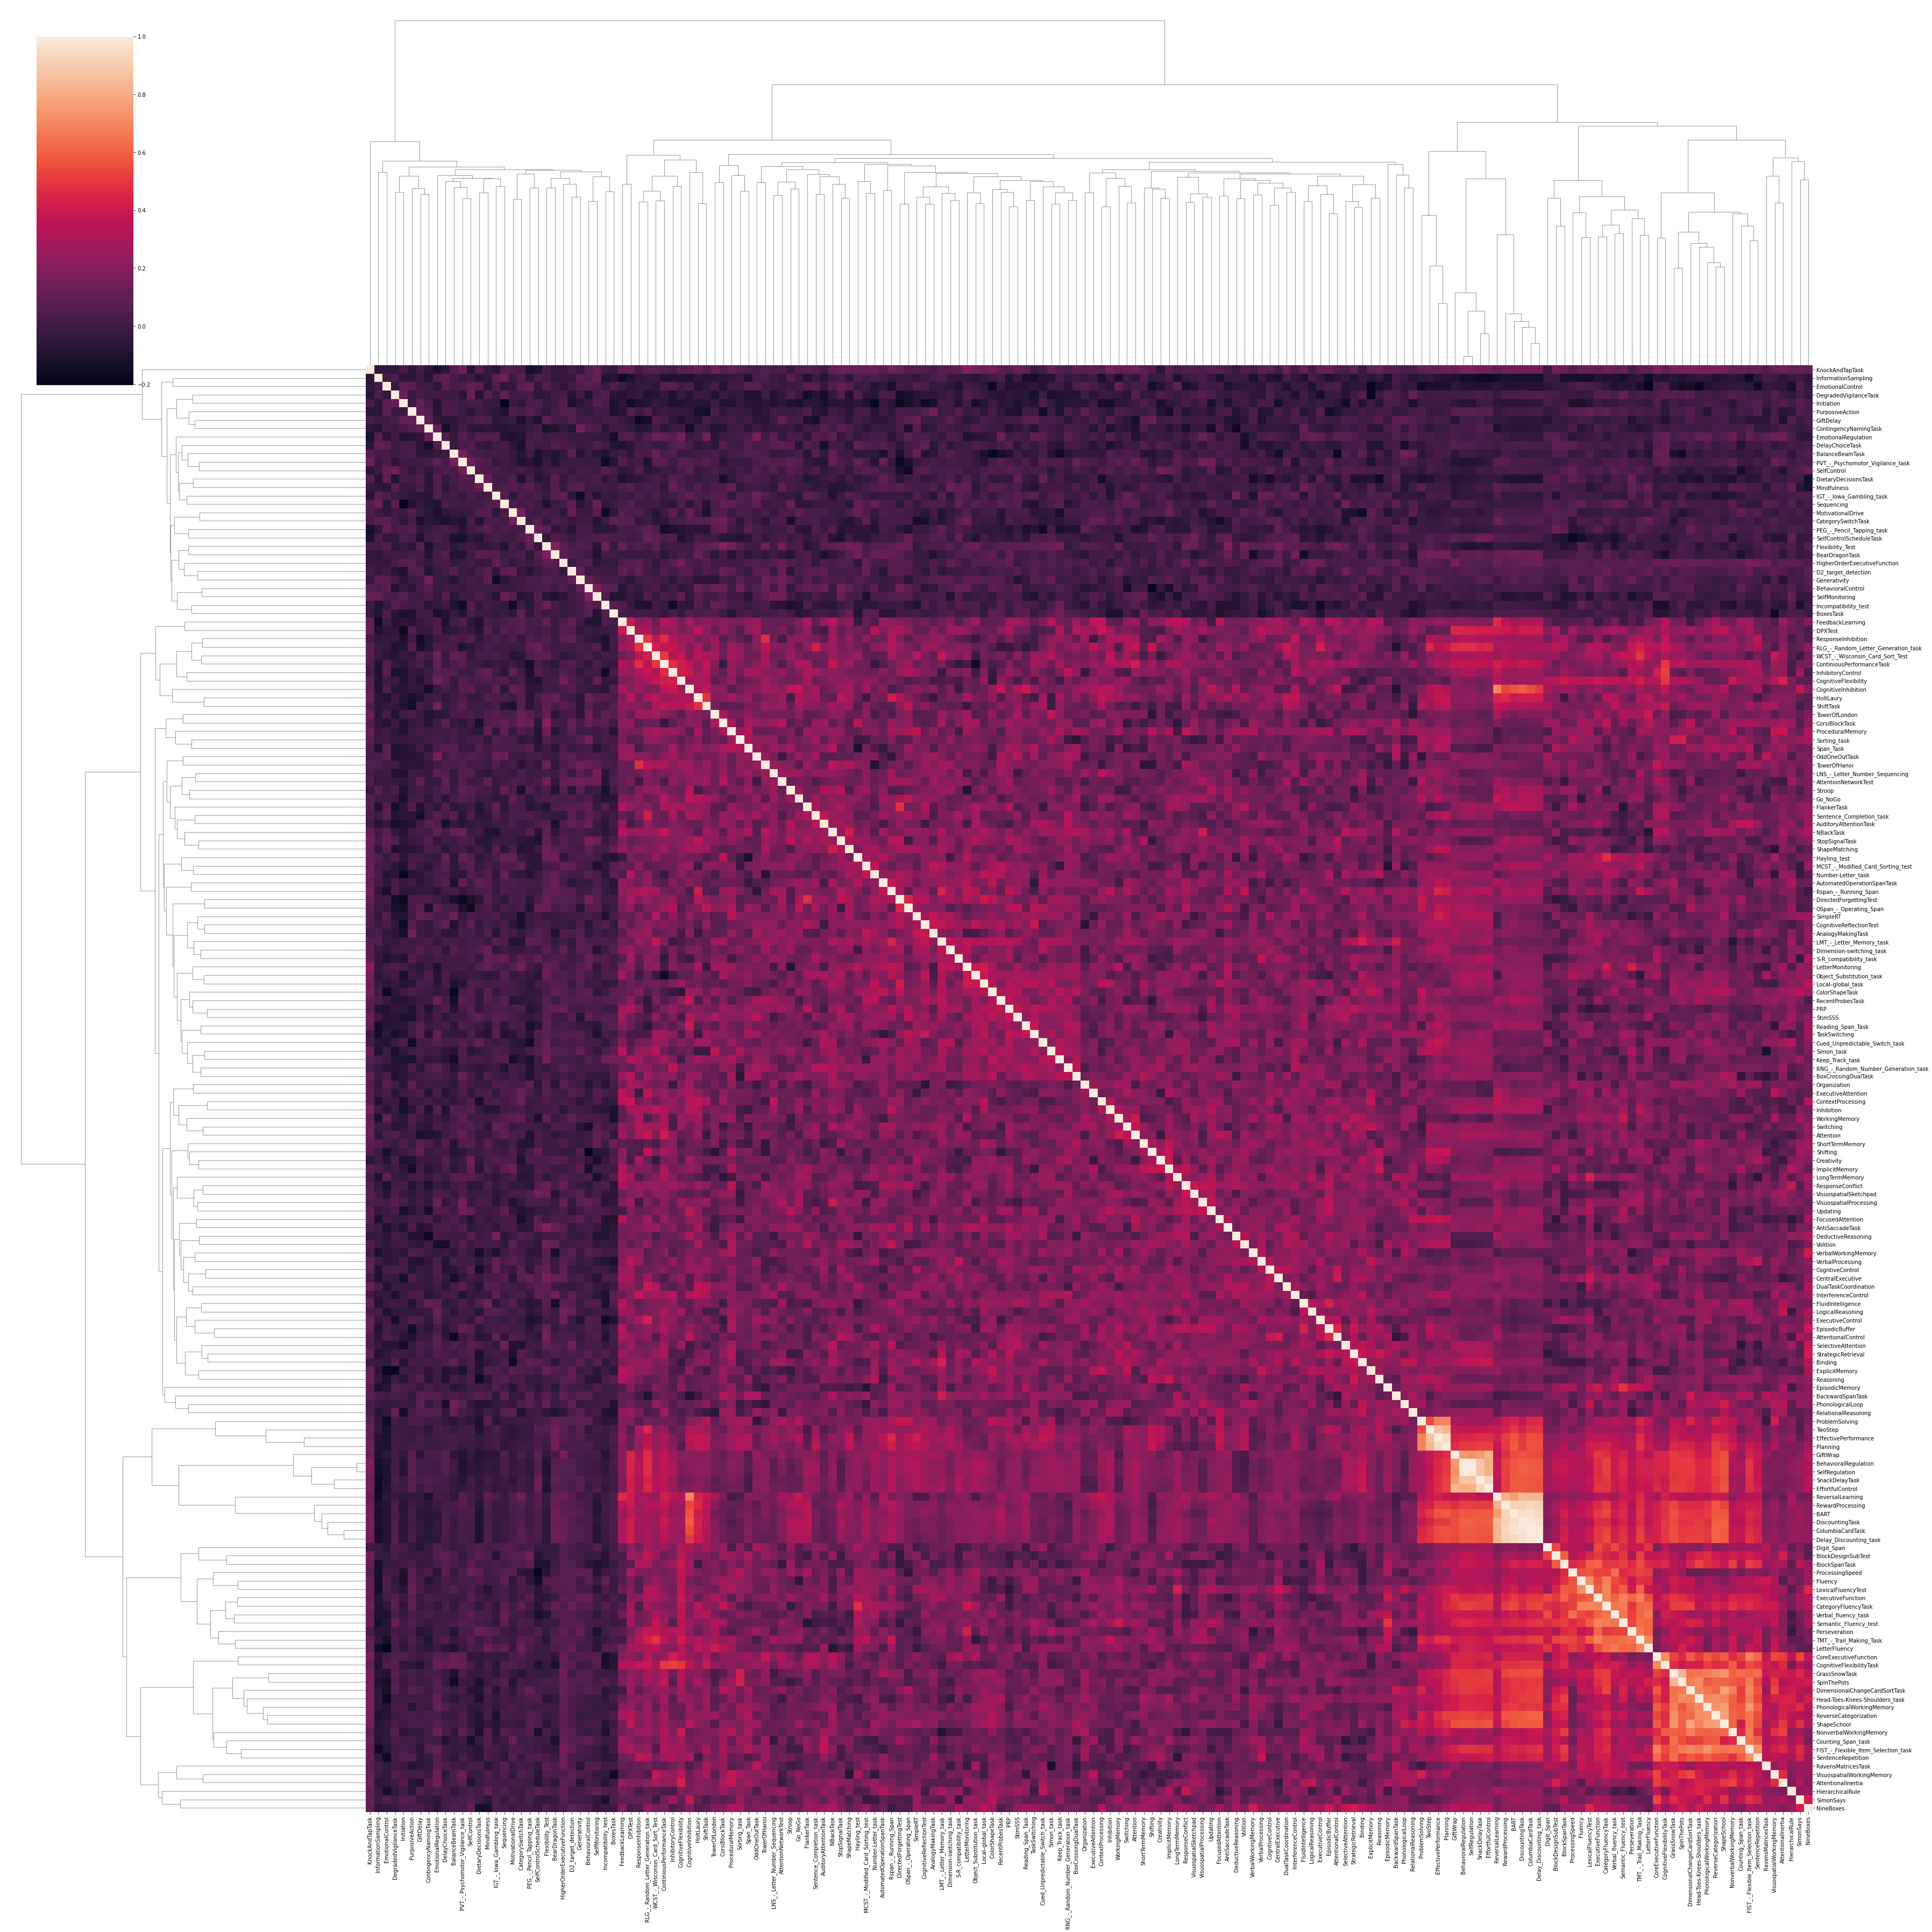

In [71]:
G_v = pd.DataFrame(model.wv.vectors, index=model.wv.index_to_key)
G_sim = cosine_similarity(G_v)
G_sim = pd.DataFrame(G_sim, index=G_v.index, columns=G_v.index)
import seaborn as sns
sns.clustermap(G_sim, figsize=(50,50))

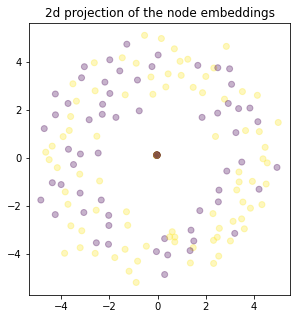

In [72]:
# visualize in a Euclidean space

node_embeddings = model.wv.vectors
node_types = [G.node_type(node_id) for node_id in model.wv.index_to_key]

from sklearn.manifold import MDS
import numpy as np
import matplotlib.pyplot as plt


node_embeddings_2d = MDS(n_components=2, metric='cosine').fit_transform(node_embeddings)

label_map = {l: i for i, l in enumerate(np.unique(node_types))}
node_colors = [label_map[t] for t in node_types]

plt.figure(figsize=(5, 5))
plt.axes().set(aspect='equal')
plt.scatter(node_embeddings_2d[:, 0], node_embeddings_2d[:, 1], c=node_colors, alpha=0.3)
plt.title('2d projection of the node embeddings')
plt.show()